---
title: "Cardiovascular Risk in South Asian Immigrants"
subtitle: "Association Between US Residence Duration and Hypertension"
author: "Adriana E. Reyes Miranda"
date: "February 3, 2026"
format:
  html:
    toc: true
    toc-depth: 3
    code-fold: true
    code-summary: "View technical details"
    self-contained: true
    theme: cosmo
    number-sections: true
execute:
  warning: false
  message: false
  echo: false
---

# Summary

**Purpose:** Assess cardiovascular risk in South Asian immigrants and examine the relationship between duration of US residence and hypertension.

**Key Findings:**
- Hypertension prevalence increases significantly with longer US residence (20% in Q1 → 45% in Q4)
- Each additional year in the US increases hypertension odds by ~5% after adjusting for age and risk factors
- Age and duration of US residence are independent predictors of hypertension

**Methods Approach:**
- **Updated CV outcome:** Diagnosed hypertension only (excludes family history)
- **Risk factors:** Age, sex, diabetes, BMI, tobacco use, alcohol use, family history (MI/stroke), diabetes medication, household income
- **Excluded variables:**
  - BP medication (post-treatment bias: 75% of cases vs 4% of non-cases)
  - Cholesterol medication (post-treatment bias: 46% of cases vs 10% of non-cases)
  - Hyperlipidemia diagnosis (likely consequence of screening: 36% of cases vs 6% of non-cases)
  - Vegetarian diet (no variation: 99.4% vegetarian, causes statistical instability)

- **Missing data:** Simple imputation with missingness indicators for fully adjusted model> **Note:** Detailed model comparisons (complete case vs. imputation, continuous vs. quartile approaches) are available in the appendix notebook.

- **Analysis:** Three nested models (unadjusted, age-adjusted, fully adjusted) using full sample

# Setup and Data Loading

In [82]:
# Import required libraries
import pandas as pd
import numpy as np
from plotnine import *
from great_tables import GT
from great_tables import style, loc
from scipy.stats import chi2_contingency, f_oneway
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Load data
df = pd.read_csv("USACHICTSI7435_DATA_LABELS_2025-12-15_1558.csv")
print(f"✓ Data loaded: {df.shape[0]} participants, {df.shape[1]} variables")

✓ Data loaded: 179 participants, 188 variables


# Data Preparation

## Variable Selection and Cleaning

In [83]:
# Clean column names
df.columns = df.columns.astype(str)
df.columns = df.columns.str.replace("'", "")
df.columns = df.columns.str.replace('\xa0', ' ')
df.columns = df.columns.str.strip()
df.columns = df.columns.str.lower()

# Map to clean variable names
col_mapping = {
    "survey date": "survey_date",
    "what is your age?": "age",
    "what is your biological sex?": "sex",
    "what is your household income?": "income",
    "in what year did you or your family arrive to the united states?": "year_arrived_us",
    "have you been diagnosed with any of the following  (choice=hypertension)": "dx_htn",
    "have you been diagnosed with any of the following  (choice=hyperlipidemia / high cholesterol)": "dx_hyperlipidemia",
    "diabetes melitus (choice=yes)": "dx_diabetes",
    "heart attack (choice=yes)": "fhx_mi",
    "stroke (choice=yes)": "fhx_stroke",
    "do you drink alcohol?": "alcohol_use",
    "do you identify yourself as": "diet_type",
    "are you prescribed any of the following (choice=medication for cholesterol)": "med_cholesterol",
    "are you prescribed any of the following (choice=medication for blood pressure)": "med_bp",
    "are you prescribed any of the following (choice=medication for diabetes mellitus)": "med_diabetes",
    "do you use tobacco?": "tobacco_use",
    "weight": "weight_lbs",
    "height": "height_inches",
    "body mass index": "bmi",
}

existing_mapping = {k: v for k, v in col_mapping.items() if k in df.columns}
df = df.rename(columns=existing_mapping)

print(f"✓ Variables renamed and selected")

✓ Variables renamed and selected


## Data Type Conversions

In [84]:
# Convert dates
df["survey_date"] = pd.to_datetime(df["survey_date"], errors="coerce")

# Convert age
df["age"] = pd.to_numeric(df["age"], errors="coerce")
df.loc[(df["age"] < 0) | (df["age"] > 120), "age"] = np.nan

# Convert year arrived
df["year_arrived_us"] = pd.to_numeric(df["year_arrived_us"], errors="coerce")
df.loc[(df["year_arrived_us"] < 1900) | (df["year_arrived_us"] > 2024), "year_arrived_us"] = np.nan

# Calculate years in US
df["arrival_date"] = pd.to_datetime(
    df["year_arrived_us"].astype("Int64").astype(str) + "-07-01",
    errors="coerce"
)
df["years_in_us"] = (df["survey_date"] - df["arrival_date"]).dt.days / 365.25
df.loc[(df["years_in_us"] < 0) | (df["years_in_us"] > 120), "years_in_us"] = np.nan

# Convert anthropometric measures
if "bmi" in df.columns:
    df["bmi"] = pd.to_numeric(df["bmi"], errors="coerce")
    df.loc[(df["bmi"] < 10) | (df["bmi"] > 80), "bmi"] = np.nan

print("✓ Data types converted")

✓ Data types converted


## Binary Variable Encoding

In [85]:
def to_binary(x):
    """Convert various representations to binary 0/1"""
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    yes_set = {"yes", "y", "true", "1", "1.0", "checked", "check", "x", "selected"}
    no_set = {"no", "n", "false", "0", "0.0", "unchecked", "uncheck", ""}
    if s in yes_set:
        return 1
    if s in no_set:
        return 0
    if len(s) > 0:
        return 1
    return np.nan

# Apply to diagnosis and medication variables
binary_vars = [
    "dx_htn", "dx_hyperlipidemia", "dx_diabetes",
    "fhx_mi", "fhx_stroke",
    "med_cholesterol", "med_bp", "med_diabetes"
]

for var in binary_vars:
    if var in df.columns:
        df[var] = df[var].apply(to_binary)

# Process lifestyle variables (preserve missing values for proper imputation)
if "tobacco_use" in df.columns:
    df["tobacco_any"] = df["tobacco_use"].apply(
        lambda x: 1 if pd.notna(x) and str(x).strip().lower() not in ['no', 'n', 'never', ''] 
        else (0 if pd.notna(x) else np.nan)
    )

if "alcohol_use" in df.columns:
    df["alcohol_any"] = df["alcohol_use"].apply(
        lambda x: 1 if pd.notna(x) and str(x).strip().lower() not in ['no', 'n', 'never', ''] 
        else (0 if pd.notna(x) else np.nan)
    )

if "diet_type" in df.columns:
    df["vegetarian"] = df["diet_type"].apply(
        lambda x: 1 if pd.notna(x) and 'vegetarian' in str(x).strip().lower() 
        else (0 if pd.notna(x) else np.nan)
    )

# Sex variable (preserve missing values)
if "sex" in df.columns:
    df["sex_male"] = df["sex"].apply(
        lambda x: 1 if pd.notna(x) and str(x).strip().lower() == 'male' 
        else (0 if pd.notna(x) and str(x).strip().lower() == 'female' else np.nan)
    )

print("✓ Binary encoding completed")

✓ Binary encoding completed


## Outcome Definition (UPDATED)

**Key Change from previous analyses:** The CV outcome now includes **only diagnosed hypertension**. 

- `dx_htn` = Diagnosed hypertension (personal diagnosis)
- `fhx_mi` and `fhx_stroke` = Family history (NOT personal diagnosis, analyzed separately)

In [86]:
# Define CV outcome: diagnosed hypertension only
df["cv_outcome"] = df["dx_htn"].copy()

# Family history composite
if "fhx_mi" in df.columns and "fhx_stroke" in df.columns:
    df["family_hx_major_cv"] = ((df["fhx_mi"] == 1) | (df["fhx_stroke"] == 1)).astype(int)
    df.loc[df["fhx_mi"].isna() & df["fhx_stroke"].isna(), "family_hx_major_cv"] = np.nan

print("\n=== CV OUTCOME DEFINITION (UPDATED) ===")
print(f"Total participants: {len(df)}")
print(f"\nPersonal CV Outcome:")
print(f"  Hypertension (dx_htn): {df['dx_htn'].sum():.0f} ({df['dx_htn'].mean()*100:.1f}%)")
if "family_hx_major_cv" in df.columns:
    print(f"\nFamily History :")
    print(f"  Family hx MI or Stroke: {df['family_hx_major_cv'].sum():.0f} ({df['family_hx_major_cv'].mean()*100:.1f}%)")
print("="*40)


=== CV OUTCOME DEFINITION (UPDATED) ===
Total participants: 179

Personal CV Outcome:
  Hypertension (dx_htn): 28 (15.6%)

Family History :
  Family hx MI or Stroke: 72 (40.2%)


## Create Analysis Sample

In [87]:
# Filter to analysis sample
df_analysis = df[
    df["years_in_us"].notna() &
    df["age"].notna() &
    df["dx_htn"].notna()
].copy()

# Create quartiles for descriptive analysis
df_analysis["years_in_us_q"] = pd.qcut(
    df_analysis["years_in_us"],
    q=4,
    labels=["Q1 (Shortest)", "Q2", "Q3", "Q4 (Longest)"],
    duplicates="drop"
)

print(f"\n=== SAMPLE SELECTION ===")
print(f"Raw sample: {len(df)} participants")
print(f"Analysis sample: {len(df_analysis)} participants ({len(df_analysis)/len(df)*100:.1f}% retention)")
print(f"Hypertension prevalence: {df_analysis['cv_outcome'].mean()*100:.1f}%")
print("="*40)


=== SAMPLE SELECTION ===
Raw sample: 179 participants
Analysis sample: 168 participants (93.9% retention)
Hypertension prevalence: 15.5%


# Descriptive Statistics

## Treatment Patterns Among Diagnosed Hypertension Cases

In [88]:
# Analyze BP medication use among those with diagnosed hypertension
if 'med_bp' in df_analysis.columns and 'cv_outcome' in df_analysis.columns:
    htn_cases = df_analysis[df_analysis['cv_outcome'] == 1].copy()
    
    print("="*60)
    print("HYPERTENSION TREATMENT PATTERNS")
    print("="*60)
    print(f"Total diagnosed hypertension cases: n={len(htn_cases)}")
    print()
    
    # BP medication use
    if htn_cases['med_bp'].notna().sum() > 0:
        n_on_meds = htn_cases['med_bp'].sum()
        n_valid = htn_cases['med_bp'].notna().sum()
        pct_on_meds = (n_on_meds / n_valid) * 100
        
        print(f"BP Medication Use:")
        print(f"  On BP medication: {int(n_on_meds)}/{n_valid} ({pct_on_meds:.1f}%)")
        print(f"  Not on BP medication: {int(n_valid - n_on_meds)}/{n_valid} ({100-pct_on_meds:.1f}%)")
        print()
        
        # Treatment by duration of residence
        if 'years_in_us_q' in htn_cases.columns:
            print("BP Medication Use by Duration of US Residence:")
            treatment_by_quartile = (
                htn_cases.groupby('years_in_us_q', observed=True)['med_bp']
                .agg(['sum', 'count', 'mean'])
                .reset_index()
            )
            treatment_by_quartile['pct'] = treatment_by_quartile['mean'] * 100
            
            for _, row in treatment_by_quartile.iterrows():
                print(f"  {row['years_in_us_q']:20s}: {int(row['sum'])}/{int(row['count'])} ({row['pct']:.1f}%)")
    else:
        print("BP medication data not available")
    
    print("="*40)
    print()
    print("Note: BP medication excluded from regression models to avoid")
    print("post-treatment bias (medication is consequence of diagnosis).")
    print("="*40)

HYPERTENSION TREATMENT PATTERNS
Total diagnosed hypertension cases: n=26

BP Medication Use:
  On BP medication: 19/26 (73.1%)
  Not on BP medication: 7/26 (26.9%)

BP Medication Use by Duration of US Residence:
  Q1 (Shortest)       : 6/6 (100.0%)
  Q2                  : 0/2 (0.0%)
  Q3                  : 3/7 (42.9%)
  Q4 (Longest)        : 10/11 (90.9%)

Note: BP medication excluded from regression models to avoid
post-treatment bias (medication is consequence of diagnosis).


## Study Population Characteristics

In [89]:
# Overall population summary
overall = pd.DataFrame([{
    "N": len(df_analysis),
    "Age, mean (SD)": f"{df_analysis['age'].mean():.1f} ({df_analysis['age'].std():.1f})",
    "Years in US, mean (SD)": f"{df_analysis['years_in_us'].mean():.1f} ({df_analysis['years_in_us'].std():.1f})",
    "Hypertension, n (%)": f"{int(df_analysis['cv_outcome'].sum())}, {df_analysis['cv_outcome'].mean()*100:.1f}%"
}])

GT(overall).tab_header(title="Study Population Overview")

GT(_tbl_data=     N Age, mean (SD) Years in US, mean (SD) Hypertension, n (%)
0  168    45.2 (12.3)            13.4 (10.9)           26, 15.5%, _body=<great_tables._gt_data.Body object at 0x70c76f571000>, _boxhead=Boxhead([ColInfo(var='N', type=<ColInfoTypeEnum.default: 1>, column_label='N', column_align='right', column_width=None), ColInfo(var='Age, mean (SD)', type=<ColInfoTypeEnum.default: 1>, column_label='Age, mean (SD)', column_align='right', column_width=None), ColInfo(var='Years in US, mean (SD)', type=<ColInfoTypeEnum.default: 1>, column_label='Years in US, mean (SD)', column_align='right', column_width=None), ColInfo(var='Hypertension, n (%)', type=<ColInfoTypeEnum.default: 1>, column_label='Hypertension, n (%)', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x70c76f54f9d0>, _spanners=Spanners([]), _heading=Heading(title='Study Population Overview', subtitle=None, preheader=None), _stubhead=None, _summary_rows=<great_tables._gt_data.SummaryRows object at 0x70c76e329b10>, _summary_rows_grand=<great_tables._gt_data.SummaryRows object at 0x70c76e3299f0>, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x70c76e32bee0>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_left_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), heading_background_co

## Variable Distributions

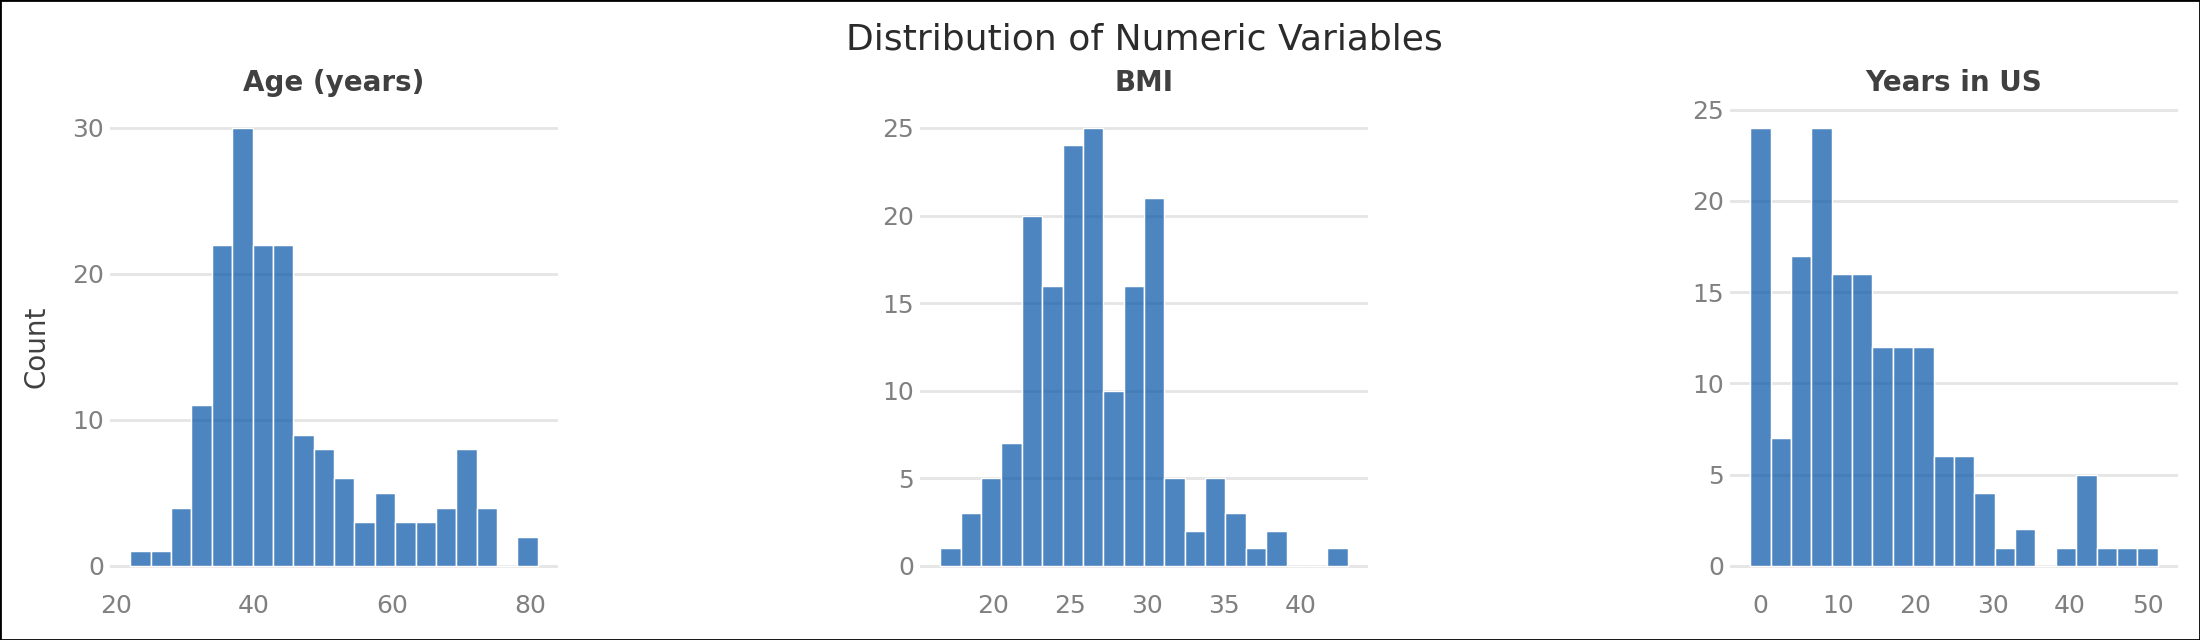

In [90]:
# Prepare data for numeric distributions
numeric_vars = ['age', 'years_in_us', 'bmi']
numeric_data = []

for var in numeric_vars:
    if var in df_analysis.columns:
        vals = df_analysis[var].dropna()
        for v in vals:
            numeric_data.append({'variable': var, 'value': v})

numeric_df = pd.DataFrame(numeric_data)

# Create labels
var_labels = {
    'age': 'Age (years)',
    'years_in_us': 'Years in US',
    'bmi': 'BMI'
}
numeric_df['var_label'] = numeric_df['variable'].map(var_labels)

# Histograms for numeric variables
p_numeric = (
    ggplot(numeric_df, aes(x='value')) +
    geom_histogram(bins=20, fill='#0051a5', alpha=0.7, color='white', size=0.3) +
    facet_wrap('~var_label', scales='free', ncol=3) +
    labs(x='', y='Count', title='Distribution of Numeric Variables') +
    theme_minimal() +
    theme(
        figure_size=(11, 3.2),
        plot_title=element_text(size=13, color='#2b2b2b', face='plain'),
        strip_text=element_text(size=10, color='#404040', face='bold'),
        axis_text=element_text(size=9, color='#808080'),
        axis_title_y=element_text(size=10, color='#404040'),
        panel_grid_minor=element_blank(),
        panel_grid_major_x=element_blank(),
        panel_spacing_x=0.15,
        plot_background=element_rect(fill='white'),
        panel_background=element_rect(fill='white')
    )
)

p_numeric

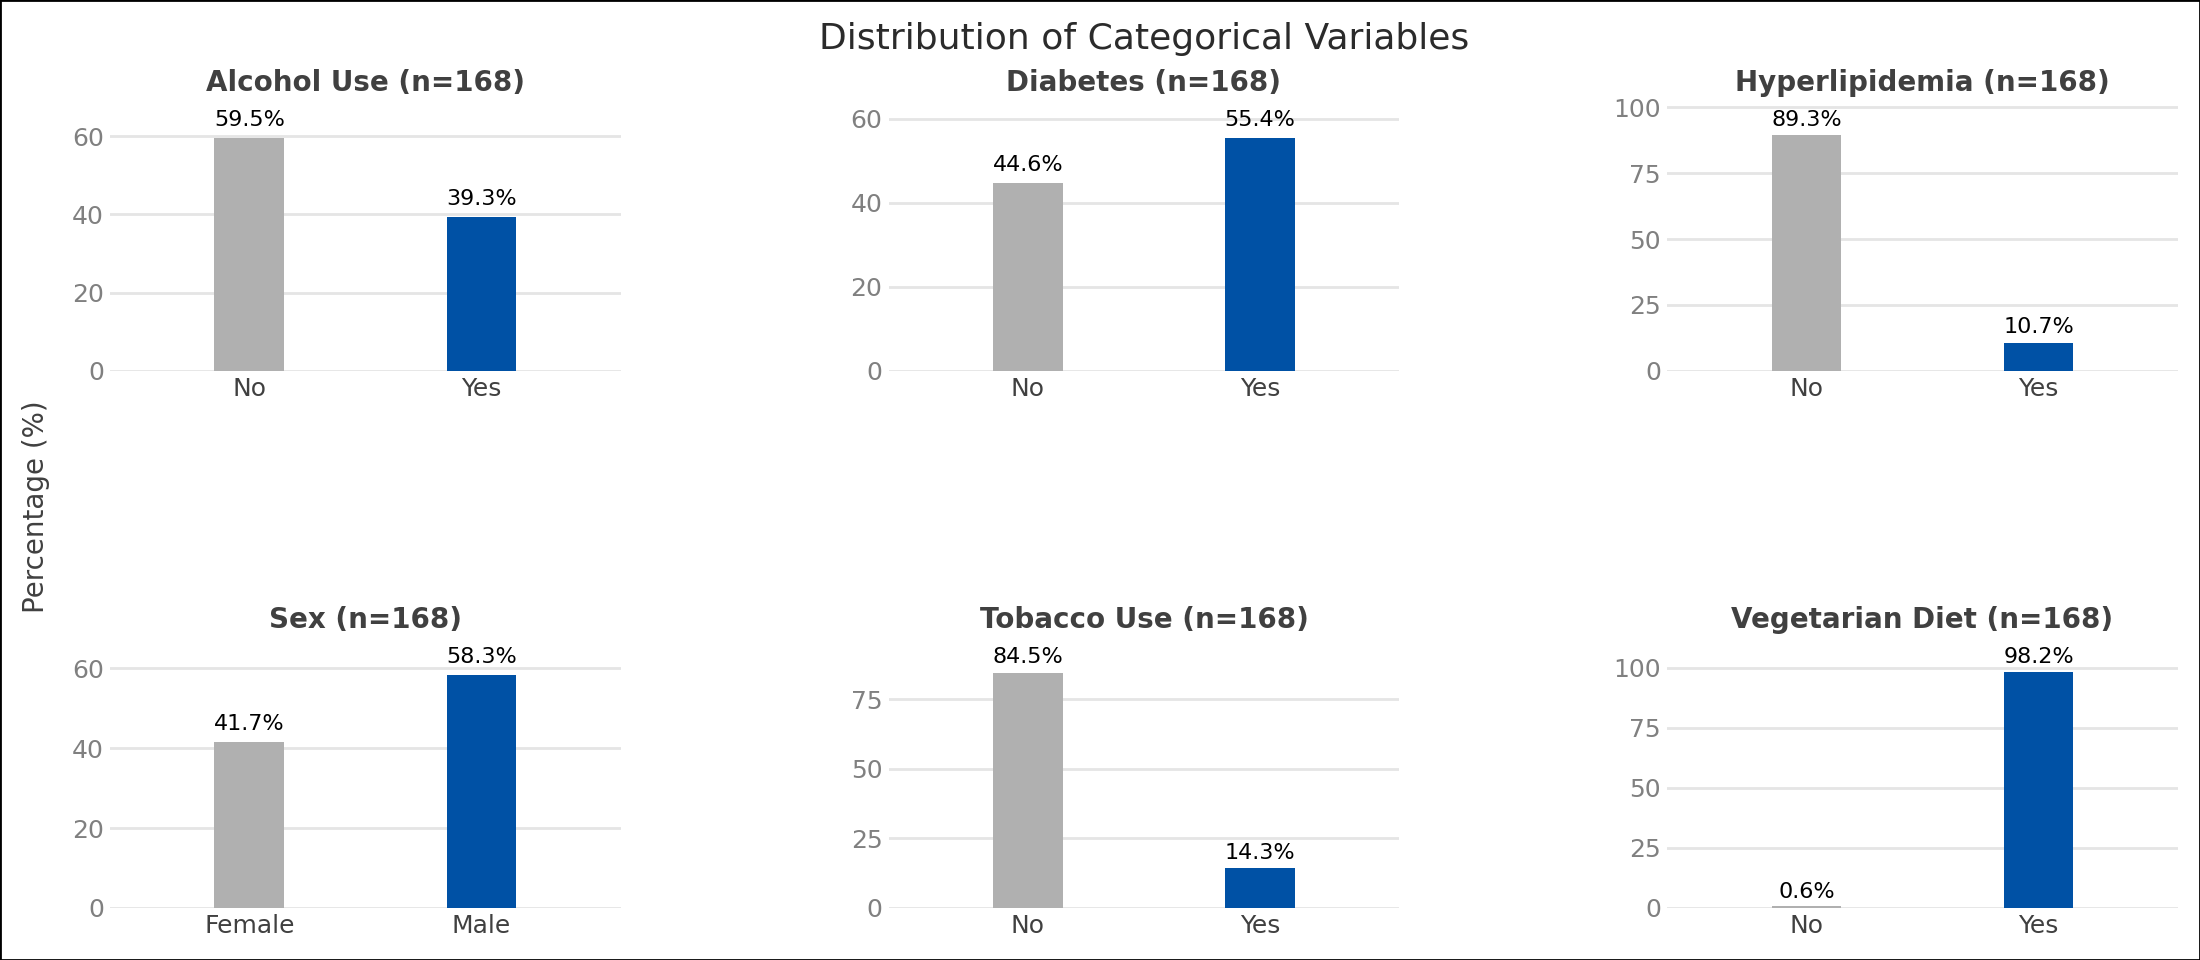

In [91]:
# Prepare data for categorical variables
categorical_vars = [
    ('sex_male', 'Sex'),
    ('dx_diabetes', 'Diabetes'),
    ('dx_hyperlipidemia', 'Hyperlipidemia'),
    ('tobacco_any', 'Tobacco Use'),
    ('alcohol_any', 'Alcohol Use'),
    ('vegetarian', 'Vegetarian Diet')
]

cat_data = []
for var, label in categorical_vars:
    if var in df_analysis.columns:
        vals = df_analysis[var].value_counts().sort_index()
        total_n = len(df_analysis)
        for idx, count in vals.items():
            # Special handling for sex variable
            if var == 'sex_male':
                cat_label = 'Male' if idx == 1 else 'Female'
            else:
                cat_label = 'Yes' if idx == 1 else 'No'
            cat_data.append({
                'variable': f'{label} (n={total_n})',
                'category': cat_label,
                'count': count,
                'pct': (count / total_n) * 100
            })

cat_df = pd.DataFrame(cat_data)

# Ensure consistent ordering and color mapping
cat_df['color'] = cat_df['category'].apply(lambda x: '#0051a5' if x in ['Yes', 'Male'] else '#b0b0b0')

# Bar charts for categorical variables
p_categorical = (
    ggplot(cat_df, aes(x='category', y='pct', fill='color')) +
    geom_col(width=0.3, show_legend=False) +
    geom_text(aes(label='pct', y='pct'), 
              format_string='{:.1f}%',
              va='bottom',
              nudge_y=2,
              size=8) +
    facet_wrap('~variable', scales='free', ncol=3) +
    scale_fill_identity() +
    labs(x='', y='Percentage (%)', title='Distribution of Categorical Variables') +
    scale_y_continuous(expand=[0, 0, 0.1, 0]) +
    theme_minimal() +
    theme(
        figure_size=(11, 4.8),
        plot_title=element_text(size=13, color='#2b2b2b', face='plain'),
        strip_text=element_text(size=10, color='#404040', face='bold'),
        axis_text_x=element_text(size=9, color='#404040'),
        axis_text_y=element_text(size=9, color='#808080'),
        axis_title_y=element_text(size=10, color='#404040'),
        axis_ticks=element_blank(),
        panel_grid_minor=element_blank(),
        panel_grid_major_x=element_blank(),
        panel_spacing_x=0.10,
        panel_spacing_y=0.1,
        plot_background=element_rect(fill='white'),
        panel_background=element_rect(fill='white')
    )

)

p_categorical


## Risk Factor Prevalence

In [ ]:
# Risk factors summary
risk_factors = []

# Metabolic
if "dx_diabetes" in df_analysis.columns:
    n_valid = df_analysis["dx_diabetes"].notna().sum()
    n_yes = df_analysis["dx_diabetes"].sum()
    risk_factors.append({
        "Risk Factor": "Diabetes mellitus",
        "N": f"{int(n_yes)}/{n_valid}",
        "Prevalence": f"{n_yes/n_valid*100:.1f}%" if n_valid > 0 else "N/A"
    })

if "dx_hyperlipidemia" in df_analysis.columns:
    n_valid = df_analysis["dx_hyperlipidemia"].notna().sum()
    n_yes = df_analysis["dx_hyperlipidemia"].sum()
    risk_factors.append({
        "Risk Factor": "Hyperlipidemia (excluded)",
        "N": f"{int(n_yes)}/{n_valid}",
        "Prevalence": f"{n_yes/n_valid*100:.1f}%" if n_valid > 0 else "N/A"
    })

if "bmi" in df_analysis.columns:
    n_valid = df_analysis["bmi"].notna().sum()
    mean_bmi = df_analysis["bmi"].mean()
    sd_bmi = df_analysis["bmi"].std()
    risk_factors.append({
        "Risk Factor": "BMI, mean (SD)",
        "N": f"n={n_valid}",
        "Prevalence": f"{mean_bmi:.1f} ({sd_bmi:.1f})" if n_valid > 0 else "N/A"
    })

# Lifestyle
for var, label in [("tobacco_any", "Tobacco use"), ("alcohol_any", "Alcohol use"), ("vegetarian", "Vegetarian diet (excluded)")]:
    if var in df_analysis.columns:
        n_valid = df_analysis[var].notna().sum()
        n_yes = df_analysis[var].sum()
        risk_factors.append({
            "Risk Factor": label,
            "N": f"{int(n_yes)}/{n_valid}",
            "Prevalence": f"{n_yes/n_valid*100:.1f}%" if n_valid > 0 else "N/A"
        })

# Family History
for var, label in [("fhx_mi", "Family history: MI"), ("fhx_stroke", "Family history: Stroke")]:
    if var in df_analysis.columns:
        n_valid = df_analysis[var].notna().sum()
        n_yes = df_analysis[var].sum()
        risk_factors.append({
            "Risk Factor": label,
            "N": f"{int(n_yes)}/{n_valid}",
            "Prevalence": f"{n_yes/n_valid*100:.1f}%" if n_valid > 0 else "N/A"
        })

# Medications
for var, label in [("med_bp", "BP medication (excluded)"), ("med_cholesterol", "Cholesterol medication (excluded)"), ("med_diabetes", "Diabetes medication")]:
    if var in df_analysis.columns:
        n_valid = df_analysis[var].notna().sum()
        n_yes = df_analysis[var].sum()
        risk_factors.append({
            "Risk Factor": label,
            "N": f"{int(n_yes)}/{n_valid}",
            "Prevalence": f"{n_yes/n_valid*100:.1f}%" if n_valid > 0 else "N/A"
        })

# Socioeconomic
if "income" in df_analysis.columns:
    # Apply same encoding as used in modeling (excludes "Decline to answer")
    income_map = {
        'Less than $25,000': 1,
        '$25,000-$50,000': 2,
        '$50,000-$100,000': 3,
        '$100,000 +': 4
    }
    n_valid = df_analysis["income"].map(income_map).notna().sum()
    risk_factors.append({
        "Risk Factor": "Household income",
        "N": f"n={n_valid}",
        "Prevalence": f"{n_valid/len(df_analysis)*100:.1f}% available"
    })

# Demographics
if "sex_male" in df_analysis.columns:
    n_valid = df_analysis["sex_male"].notna().sum()
    n_male = df_analysis["sex_male"].sum()
    risk_factors.append({
        "Risk Factor": "Male sex",
        "N": f"{int(n_male)}/{n_valid}",
        "Prevalence": f"{n_male/n_valid*100:.1f}%" if n_valid > 0 else "N/A"
    })

risk_df = pd.DataFrame(risk_factors)

GT(risk_df).tab_header(
    title="Risk Factor Prevalence",
    subtitle=f"Analysis sample (n={len(df_analysis)}) - Excluded variables marked; 'Decline to answer' treated as missing for income"
)


GT(_tbl_data=                          Risk Factor        N       Prevalence
0                   Diabetes mellitus   93/168            55.4%
1           Hyperlipidemia (excluded)   18/168            10.7%
2                      BMI, mean (SD)    n=167       26.7 (4.3)
3                         Tobacco use   24/166            14.5%
4                         Alcohol use   66/166            39.8%
5          Vegetarian diet (excluded)  165/166            99.4%
6                  Family history: MI   58/168            34.5%
7              Family history: Stroke   22/168            13.1%
8            BP medication (excluded)   25/168            14.9%
9   Cholesterol medication (excluded)   25/168            14.9%
10                Diabetes medication   12/168             7.1%
11                   Household income    n=123  73.2% available
12                           Male sex   98/168            58.3%, _body=<great_tables._gt_data.Body object at 0x70c76cb4dc30>, _boxhead=Boxhead([ColInfo(var='Risk Factor', type=<ColInfoTypeEnum.default: 1>, column_label='Risk Factor', column_align='left', column_width=None), ColInfo(var='N', type=<ColInfoTypeEnum.default: 1>, column_label='N', column_align='left', column_width=None), ColInfo(var='Prevalence', type=<ColInfoTypeEnum.default: 1>, column_label='Prevalence', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x70c76e2c9210>, _spanners=Spanners([]), _heading=Heading(title='Risk Factor Prevalence', subtitle="Analysis sample (n=168) - Excluded variables marked; 'Decline to answer' treated as missing for income", preheader=None), _stubhead=None, _summary_rows=<great_tables._gt_data.SummaryRows object at 0x70c76cb4ffd0>, _summary_rows_grand=<great_tables._gt_data.SummaryRows object at 0x70c76cb4fe80>, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x70c76cb4fcd0>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_b

## Hypertension by Duration of US Residence

In [93]:
# By quartiles
by_quartile = (
    df_analysis
    .groupby("years_in_us_q", observed=True)
    .agg(
        N=("years_in_us_q", "size"),
        years_us_mean=("years_in_us", "mean"),
        years_us_sd=("years_in_us", "std"),
        age_mean=("age", "mean"),
        age_sd=("age", "std"),
        htn_n=("cv_outcome", "sum"),
        htn_pct=("cv_outcome", lambda s: s.mean() * 100),
    )
    .reset_index()
)

by_quartile["Years in US"] = by_quartile.apply(lambda r: f"{r['years_us_mean']:.1f} ({r['years_us_sd']:.1f})", axis=1)
by_quartile["Age"] = by_quartile.apply(lambda r: f"{r['age_mean']:.1f} ({r['age_sd']:.1f})", axis=1)
by_quartile["Hypertension"] = by_quartile.apply(lambda r: f"{int(r['htn_n'])}, {r['htn_pct']:.1f}%", axis=1)

display_cols = ["years_in_us_q", "N", "Years in US", "Age", "Hypertension"]

# Statistical test
contingency = pd.crosstab(df_analysis["years_in_us_q"], df_analysis["cv_outcome"])
chi2, p_val, _, _ = chi2_contingency(contingency)

GT(by_quartile[display_cols]).tab_header(
    title="Hypertension by Duration of US Residence",
    subtitle=f"Chi-square test: χ²={chi2:.2f}, p={p_val:.4f}"
).cols_label(
    years_in_us_q="Quartile"
)

GT(_tbl_data=   years_in_us_q   N Years in US          Age Hypertension
0  Q1 (Shortest)  48   2.6 (2.2)  46.5 (16.8)     6, 12.5%
1             Q2  39   8.9 (1.5)  40.4 (10.2)      2, 5.1%
2             Q3  40  15.1 (2.3)   41.5 (4.6)     7, 17.5%
3   Q4 (Longest)  41  28.7 (8.9)   51.6 (9.8)    11, 26.8%, _body=<great_tables._gt_data.Body object at 0x70c76cb15e40>, _boxhead=Boxhead([ColInfo(var='years_in_us_q', type=<ColInfoTypeEnum.default: 1>, column_label='Quartile', column_align='center', column_width=None), ColInfo(var='N', type=<ColInfoTypeEnum.default: 1>, column_label='N', column_align='right', column_width=None), ColInfo(var='Years in US', type=<ColInfoTypeEnum.default: 1>, column_label='Years in US', column_align='right', column_width=None), ColInfo(var='Age', type=<ColInfoTypeEnum.default: 1>, column_label='Age', column_align='right', column_width=None), ColInfo(var='Hypertension', type=<ColInfoTypeEnum.default: 1>, column_label='Hypertension', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x70c7717fb250>, _spanners=Spanners([]), _heading=Heading(title='Hypertension by Duration of US Residence', subtitle='Chi-square test: χ²=7.68, p=0.0530', preheader=None), _stubhead=None, _summary_rows=<great_tables._gt_data.SummaryRows object at 0x70c76cb15a20>, _summary_rows_grand=<great_tables._gt_data.SummaryRows object at 0x70c76cb15ed0>, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x70c76cb157e0>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_lef

## Visualization: Hypertension Prevalence by Quartile

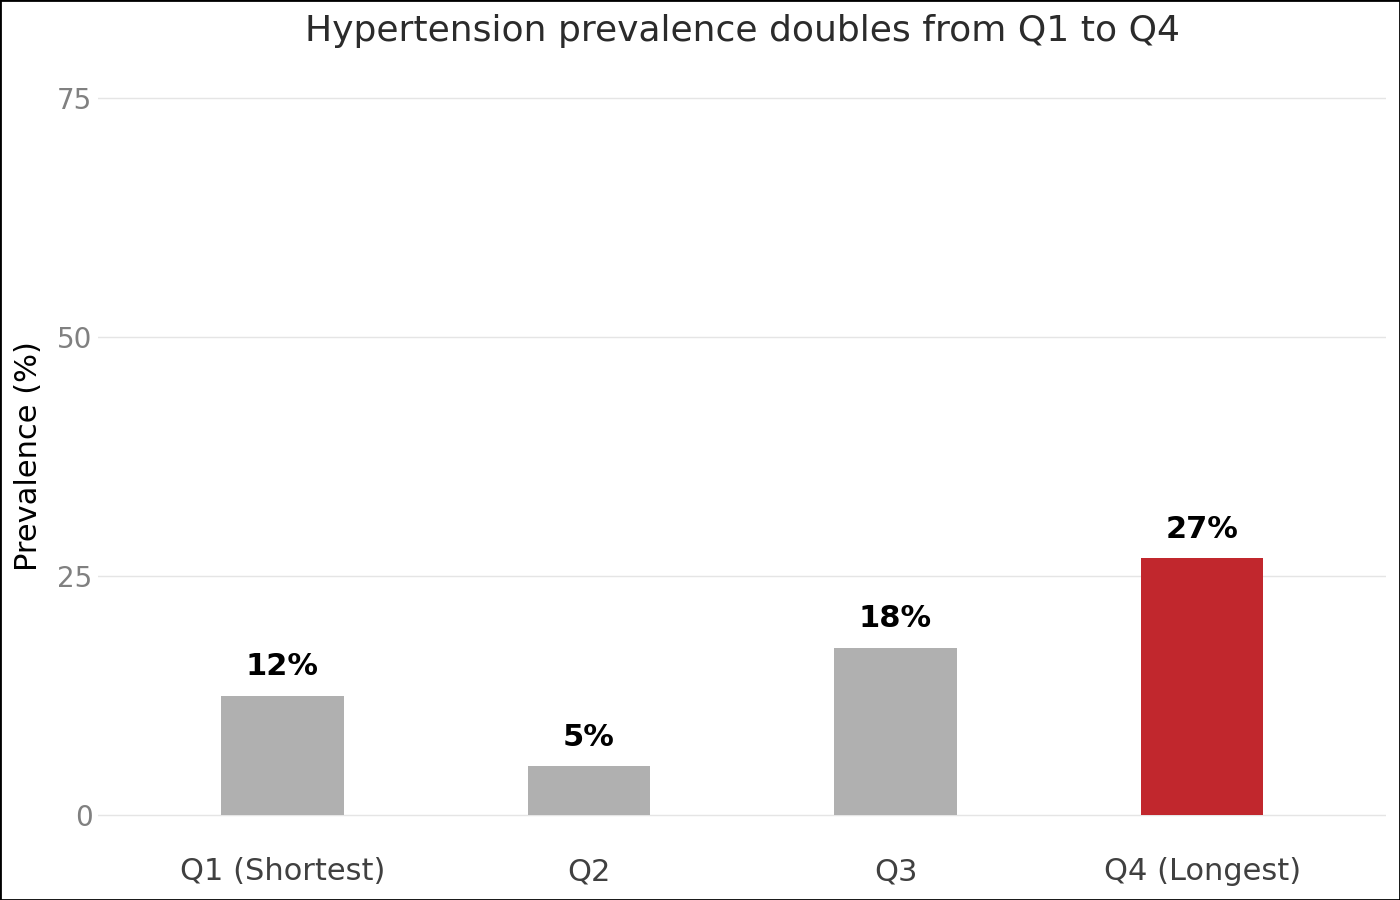

In [94]:
# Prepare plot data
plot_data = df_analysis.groupby('years_in_us_q', observed=True)['cv_outcome'].mean().reset_index()
plot_data.columns = ['quartile', 'prevalence']
plot_data['prevalence'] = plot_data['prevalence'] * 100
plot_data['quartile'] = plot_data['quartile'].astype(str)

# Highlight highest
plot_data['color'] = ['#c1272d' if x == plot_data['prevalence'].max() else '#b0b0b0' for x in plot_data['prevalence']]

p = (
    ggplot(plot_data, aes(x='quartile', y='prevalence', fill='color')) +
    geom_col(width=0.40, show_legend=False) +
    geom_text(aes(label='prevalence'), 
              format_string='{:.0f}%',
              va='bottom',
              nudge_y=1.5,
              size=11,
              fontweight='bold') +
    scale_fill_identity() +
    labs(title='Hypertension prevalence doubles from Q1 to Q4', 
         x='', 
         y='Prevalence (%)') +
    scale_y_continuous(limits=[0, 75], breaks=[0, 25, 50, 75]) +
    theme_minimal() +
    theme(
        figure_size=(7, 4.5),
        plot_title=element_text(size=13, color='#2b2b2b', face='plain'),
        axis_text_x=element_text(size=11, color='#404040'),
        axis_text_y=element_text(size=10, color='#808080'),
        axis_ticks=element_blank(),
        panel_grid_major_x=element_blank(),
        panel_grid_minor=element_blank(),
        panel_grid_major_y=element_line(color='#e5e5e5', size=0.5),
        plot_background=element_rect(fill='white'),
        panel_background=element_rect(fill='white')
    )
)

p

# Statistical Modeling

## Model Setup and Missing Data Assessment

## Variable Definitions and Treatment

::: {.callout-note collapse="true"}
## View Complete Variable Definitions

### Outcome Variable
- **cv_outcome / dx_htn**: Diagnosed hypertension (binary: 0/1)
  - Source: Self-reported diagnosis
  - Encoding: Binary conversion using standardized function (yes/checked/1 → 1; no/unchecked/0 → 0)
  - Missing: Excluded from analysis sample

### Primary Predictor
- **years_in_us**: Duration of US residence (continuous, years)
  - Calculation: Survey date minus arrival year (assumed July 1st)
  - Range validation: 0-120 years (values outside range treated as missing)
  - Missing: Excluded from analysis sample

### Demographics
- **age**: Age in years (continuous)
  - Range validation: 0-120 years (values outside range treated as missing)
  - Missing: Excluded from analysis sample
  
- **sex_male**: Biological sex (binary: 0=female, 1=male)
  - Encoding: Male=1, Female=0, Missing=NaN
  - Missing: Imputed with most frequent value; indicator added if ≥10% missing

### Metabolic Risk Factors
- **dx_diabetes**: Diagnosed diabetes mellitus (binary: 0/1)
  - Encoding: Same as dx_htn
  - Missing: Imputed with most frequent value; indicator added if ≥10% missing
  
- **dx_hyperlipidemia**: Diagnosed high cholesterol (EXCLUDED from regression models)
  - Likely consequence of increased screening/medical attention after hypertension diagnosis (36% of cases vs. 6% of non-cases)
  - Causes moderate separation leading to inflated confidence intervals
  
- **bmi**: Body mass index (continuous)
  - Range validation: 10-80 (values outside range treated as missing)
  - Missing: Imputed with median; indicator added if ≥10% missing

### Lifestyle Factors
- **tobacco_any**: Any tobacco use (binary: 0/1)
  - Note: Missing ≠ non-use; proper imputation avoids bias from differential non-response
  - Missing: Imputed with most frequent value; indicator added if ≥10% missing
  - Rationale: Missing ≠ non-use; proper imputation avoids bias from differential non-response
  
- **alcohol_any**: Any alcohol use (binary: 0/1)
  - Encoding: Any response except "no"/"never" → 1; explicit "no"/"never" → 0; Missing → NaN
  - Insufficient variation (99.4% vegetarian, only 1 non-vegetarian in sample)
- **vegetarian**: Vegetarian or vegan diet (EXCLUDED from regression models)

### Family History
- **fhx_mi**: Family history of myocardial infarction (binary: 0/1)
  - Encoding: Same as dx_htn
  - Missing: Imputed with most frequent value; indicator added if ≥10% missing
  
- **fhx_stroke**: Family history of stroke (binary: 0/1)
  - Encoding: Same as dx_htn
  - Missing: Imputed with most frequent value; indicator added if ≥10% missing

### Medications
- **med_cholesterol**: Prescribed cholesterol medication (binary: 0/1)
  - Encoding: Same as dx_htn
  - Missing: Imputed with most frequent value; indicator added if ≥10% missing
  
- **med_diabetes**: Prescribed diabetes medication (binary: 0/1)
  - Encoding: Same as dx_htn
  - Missing: Imputed with most frequent value; indicator added if ≥10% missing

- **med_bp**: Blood pressure medication (EXCLUDED from regression models)
  - Rationale: BP medication is prescribed as a consequence of hypertension diagnosis, creating post-treatment bias
  - 75% of diagnosed cases are on BP medication vs. 4% of non-diagnosed
  - Prescribed as consequence of hypertension diagnosis, creating post-treatment bias (75% of cases vs. 4% of non-cases)
  - Near-perfect separation causes statistical instability (extremely wide confidence intervals)
  - Analyzed separately as treatment pattern among diagnosed cases

### Socioeconomic Factor
- **income**: Household income (ordinal scale)
  - Original: Categorical ranges
  - Encoding: Ordinal scale (1='Less than $25k', 2='$25-50k', 3='$50-100k', 4='$100k+')
  - Interpretation: OR represents moving up one income category
  - Missing: Imputed with median; indicator added if ≥10% missing
  - Note: "Decline to answer" treated as missing

### Missing Data Strategy
- **Complete case exclusion**: Outcome (dx_htn), primary predictor (years_in_us), and age
- **Simple imputation**: All other variables
  - Numeric variables (bmi, income): Median imputation
  - Binary variables: Most frequent value imputation
- **Missingness indicators**: Binary indicators added for variables with ≥10% missing data
- **Multicollinearity check**: Missingness indicators removed if correlation >0.95 with original variable

*Note: This approach retains full sample size while maintaining transparency about where data were imputed.*
:::

*Note: This approach retains full sample size while maintaining transparency about where data were imputed.*

In [95]:
# Define feature set
# Excluded variables (see documentation for rationale):
#   - med_bp: Post-treatment bias (75% cases vs 4% non-cases)
#   - med_cholesterol: Post-treatment bias (46% cases vs 10% non-cases)
#   - dx_hyperlipidemia: Likely screening consequence (36% cases vs 6% non-cases)
#   - vegetarian: No variation (99.4% vegetarian, only 1 non-vegetarian)

feature_vars = [
    'years_in_us',
    'age',
    'dx_diabetes',
    'bmi',
    'tobacco_any',
    'alcohol_any',
    'fhx_mi',
    'fhx_stroke',
    'med_diabetes',
    'income',
]

if 'sex_male' in df_analysis.columns:
    feature_vars.append('sex_male')

# Check which are available
available_features = [f for f in feature_vars if f in df_analysis.columns]

print("="*60)
print("MODELING FEATURES")
print("="*60)
print(f"Features: {available_features}")
print("\nMissing Data:")
for col in available_features:
    n_miss = df_analysis[col].isna().sum()
    pct_miss = (n_miss / len(df_analysis)) * 100
    print(f"  {col:20s}: {n_miss:4d} missing ({pct_miss:5.1f}%)")
print("="*60)

MODELING FEATURES
Features: ['years_in_us', 'age', 'dx_diabetes', 'bmi', 'tobacco_any', 'alcohol_any', 'fhx_mi', 'fhx_stroke', 'med_diabetes', 'income', 'sex_male']

Missing Data:
  years_in_us         :    0 missing (  0.0%)
  age                 :    0 missing (  0.0%)
  dx_diabetes         :    0 missing (  0.0%)
  bmi                 :    1 missing (  0.6%)
  tobacco_any         :    2 missing (  1.2%)
  alcohol_any         :    2 missing (  1.2%)
  fhx_mi              :    0 missing (  0.0%)
  fhx_stroke          :    0 missing (  0.0%)
  med_diabetes        :    0 missing (  0.0%)
  income              :    2 missing (  1.2%)
  sex_male            :    0 missing (  0.0%)


## Prepare Modeling Dataset

In [ ]:
# Create modeling dataset (use full sample for etiological analysis)
X_full = df_analysis[available_features].copy()
y_full = df_analysis['cv_outcome'].copy()

# Encode income as ordinal numeric variable for modeling
if 'income' in X_full.columns:
    print("\n=== INCOME ENCODING DIAGNOSTICS ===")
    print(f"Missing BEFORE encoding: {X_full['income'].isna().sum()}")
    print(f"\nUnique income values in data:")
    print(X_full['income'].value_counts(dropna=False).sort_index())
    
    # Map income categories to ordinal scale (1-4)
    # Each unit increase represents moving up one income bracket
    income_map = {
        'Less than $25,000': 1,
        '$25,000-$50,000': 2,
        '$50,000-$100,000': 3,
        '$100,000 +': 4
        # 'Decline to answer' is intentionally not mapped (remains as missing)
    }
    
    # Check for unmapped values
    unmapped = X_full['income'].dropna().unique()
    unmapped_list = [val for val in unmapped if val not in income_map]
    if unmapped_list:
        print(f"\n⚠ WARNING: {len(unmapped_list)} income values not in mapping:")
        for val in unmapped_list:
            n_cases = (X_full['income'] == val).sum()
            print(f"  '{val}' (n={n_cases})")
    
    X_full['income'] = X_full['income'].map(income_map)
    print(f"\nMissing AFTER encoding: {X_full['income'].isna().sum()}")
    print(f"✓ Income encoded as ordinal scale (1-4, where 1=lowest, 4=highest)")
    print("="*40)

print(f"\nModeling sample: n={len(X_full)} (HTN prevalence: {y_full.mean()*100:.1f}%)")


=== INCOME ENCODING DIAGNOSTICS ===
Missing BEFORE encoding: 2

Unique income values in data:
income
$100,000 +           89
$25,000-$50,000      10
$50,000-$100,000     15
Decline to answer    43
Less than $25,000     9
NaN                   2
Name: count, dtype: int64

⚠ WARNING: 1 income values not in mapping:
  'Decline to answer' (n=43)

Missing AFTER encoding: 45
✓ Income encoded as ordinal numeric (1-11)

Modeling sample: n=168 (HTN prevalence: 15.5%)


## Model 1: Unadjusted (Years in US Only)

In [97]:
# Model 1: Years in US only (UNADJUSTED - may be confounded by age)
import statsmodels.api as sm

X_m1 = X_full[['years_in_us']].copy()

# Add constant for statsmodels
X_m1_const = sm.add_constant(X_m1)

# Fit logistic regression with statsmodels to get p-values
model_m1 = sm.Logit(y_full, X_m1_const).fit(disp=0)

print("="*60)
print("MODEL 1: UNADJUSTED (Years in US Only)")
print("="*60)
print(f"Sample size: n={len(X_m1)}")
print(f"Note: This model may be confounded by age\n")

# Create results table
results_m1 = pd.DataFrame({
    'Variable': ['Years in US'],
    'Coefficient': [model_m1.params['years_in_us']],
    'SE': [model_m1.bse['years_in_us']],
    'OR': [np.exp(model_m1.params['years_in_us'])],
    'OR 95% CI': [f"({np.exp(model_m1.conf_int().loc['years_in_us', 0]):.2f}, {np.exp(model_m1.conf_int().loc['years_in_us', 1]):.2f})"],
    'p-value': [model_m1.pvalues['years_in_us']]
})

# Format p-values
results_m1['p-value'] = results_m1['p-value'].apply(lambda x: f'{x:.4f}' if x >= 0.001 else '<0.001')

GT(results_m1).tab_header(
    title="Model 1: Unadjusted",
    subtitle=f"n={len(X_m1)} | Pseudo-R² = {model_m1.prsquared:.3f}"
).fmt_number(
    columns=['Coefficient', 'SE', 'OR'],
    decimals=3
)

MODEL 1: UNADJUSTED (Years in US Only)
Sample size: n=168
Note: This model may be confounded by age



GT(_tbl_data=      Variable  Coefficient        SE        OR     OR 95% CI p-value
0  Years in US     0.047916  0.017817  1.049082  (1.01, 1.09)  0.0072, _body=<great_tables._gt_data.Body object at 0x70c76f641a80>, _boxhead=Boxhead([ColInfo(var='Variable', type=<ColInfoTypeEnum.default: 1>, column_label='Variable', column_align='left', column_width=None), ColInfo(var='Coefficient', type=<ColInfoTypeEnum.default: 1>, column_label='Coefficient', column_align='right', column_width=None), ColInfo(var='SE', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='OR', type=<ColInfoTypeEnum.default: 1>, column_label='OR', column_align='right', column_width=None), ColInfo(var='OR 95% CI', type=<ColInfoTypeEnum.default: 1>, column_label='OR 95% CI', column_align='right', column_width=None), ColInfo(var='p-value', type=<ColInfoTypeEnum.default: 1>, column_label='p-value', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x70c7706fe770>, _spanners=Spanners([]), _heading=Heading(title='Model 1: Unadjusted', subtitle='n=168 | Pseudo-R² = 0.049', preheader=None), _stubhead=None, _summary_rows=<great_tables._gt_data.SummaryRows object at 0x70c76cc79930>, _summary_rows_grand=<great_tables._gt_data.SummaryRows object at 0x70c76cc7a1d0>, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x70c76cc7a2c0>, _formats=[<great_tables._gt_data.FormatInfo object at 0x70c76cc78d90>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_left_style=Options

## Model 2: Age-Adjusted (Years in US + Age)

In [98]:
# Model 2: Years in US + Age (PRIMARY MODEL - controls for confounding)
X_m2 = X_full[['years_in_us', 'age']].copy()

# Add constant for statsmodels
X_m2_const = sm.add_constant(X_m2)

# Fit logistic regression with statsmodels to get p-values
model_m2 = sm.Logit(y_full, X_m2_const).fit(disp=0)

print("="*60)
print("MODEL 2: AGE-ADJUSTED (Years in US + Age) - PRIMARY MODEL")
print("="*60)
print(f"Sample size: n={len(X_m2)}")
print(f"This model controls for age confounding\n")

# Create results table
var_names = {'years_in_us': 'Years in US', 'age': 'Age'}
results_m2 = pd.DataFrame({
    'Variable': [var_names[v] for v in ['years_in_us', 'age']],
    'Coefficient': [model_m2.params[v] for v in ['years_in_us', 'age']],
    'SE': [model_m2.bse[v] for v in ['years_in_us', 'age']],
    'OR': [np.exp(model_m2.params[v]) for v in ['years_in_us', 'age']],
    'OR 95% CI': [f"({np.exp(model_m2.conf_int().loc[v, 0]):.2f}, {np.exp(model_m2.conf_int().loc[v, 1]):.2f})" for v in ['years_in_us', 'age']],
    'p-value': [model_m2.pvalues[v] for v in ['years_in_us', 'age']]
})

# Format p-values
results_m2['p-value'] = results_m2['p-value'].apply(lambda x: f'{x:.4f}' if x >= 0.001 else '<0.001')

GT(results_m2).tab_header(
    title="Model 2: Age-Adjusted (PRIMARY MODEL)",
    subtitle=f"n={len(X_m2)} | Pseudo-R² = {model_m2.prsquared:.3f}"
).fmt_number(
    columns=['Coefficient', 'SE', 'OR'],
    decimals=3
)

MODEL 2: AGE-ADJUSTED (Years in US + Age) - PRIMARY MODEL
Sample size: n=168
This model controls for age confounding



GT(_tbl_data=      Variable  Coefficient        SE        OR     OR 95% CI p-value
0  Years in US     0.033279  0.017802  1.033839  (1.00, 1.07)  0.0616
1          Age     0.056904  0.017051  1.058554  (1.02, 1.09)  <0.001, _body=<great_tables._gt_data.Body object at 0x70c76fcab8e0>, _boxhead=Boxhead([ColInfo(var='Variable', type=<ColInfoTypeEnum.default: 1>, column_label='Variable', column_align='left', column_width=None), ColInfo(var='Coefficient', type=<ColInfoTypeEnum.default: 1>, column_label='Coefficient', column_align='right', column_width=None), ColInfo(var='SE', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='OR', type=<ColInfoTypeEnum.default: 1>, column_label='OR', column_align='right', column_width=None), ColInfo(var='OR 95% CI', type=<ColInfoTypeEnum.default: 1>, column_label='OR 95% CI', column_align='right', column_width=None), ColInfo(var='p-value', type=<ColInfoTypeEnum.default: 1>, column_label='p-value', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x70c77053b790>, _spanners=Spanners([]), _heading=Heading(title='Model 2: Age-Adjusted (PRIMARY MODEL)', subtitle='n=168 | Pseudo-R² = 0.123', preheader=None), _stubhead=None, _summary_rows=<great_tables._gt_data.SummaryRows object at 0x70c76e2f1990>, _summary_rows_grand=<great_tables._gt_data.SummaryRows object at 0x70c76e2f1ba0>, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x70c76e2f1ab0>, _formats=[<great_tables._gt_data.FormatInfo object at 0x70c76e2f1b70>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=

## Model 3: Fully Adjusted (All Risk Factors)

- Performs comparably to more complex imputation methods (see appendix for comparisons)

**Modeling Approach:** We use logistic regression with simple imputation and missingness indicators. This approach was chosen because:- Balances statistical power with interpretability

- Retains full sample (no data loss from missing values)- Maintains transparency (missingness indicators show where data were imputed)

In [99]:
# Identify numeric vs binary
numeric_cols = []
binary_cols = []

for col in available_features:
    unique_vals = X_full[col].dropna().unique()
    # Check if binary (0/1)
    if len(unique_vals) <= 2 and set(unique_vals).issubset({0, 1, 0.0, 1.0}):
        binary_cols.append(col)
    # Check if contains any string values (like '$100,000 +')
    elif any(isinstance(val, str) for val in unique_vals):
        binary_cols.append(col)
    # Check if dtype is object
    elif X_full[col].dtype == 'object':
        binary_cols.append(col)
    # Otherwise treat as numeric
    else:
        numeric_cols.append(col)

print("="*60)
print("MODEL 3: FULLY ADJUSTED (All Risk Factors)")
print("="*60)
print(f"Numeric features: {numeric_cols}")
print(f"Binary features: {binary_cols}")
print("="*60)

# Detailed missingness report
print("\nDETAILED MISSING DATA ANALYSIS:")
print("-"*60)
for col in available_features:
    n_missing = X_full[col].isna().sum()
    pct_missing = (n_missing / len(X_full)) * 100
    col_type = "Numeric" if col in numeric_cols else "Binary"
    impute_strategy = "median" if col in numeric_cols else "most_frequent"
    will_add_indicator = "YES" if pct_missing >= 10 else "NO"
    
    print(f"{col:25s} | {col_type:8s} | Missing: {n_missing:3d} ({pct_missing:5.1f}%) | "
          f"Impute: {impute_strategy:13s} | Add indicator: {will_add_indicator}")
print("-"*60)
print()

# Create imputer
if len(numeric_cols) > 0 and len(binary_cols) > 0:
    imputer = ColumnTransformer(
        transformers=[
            ('num', SimpleImputer(strategy='median'), numeric_cols),
            ('bin', SimpleImputer(strategy='most_frequent'), binary_cols)
        ]
    )
elif len(numeric_cols) > 0:
    imputer = SimpleImputer(strategy='median')
else:
    imputer = SimpleImputer(strategy='most_frequent')

# Add missingness indicators
X_full_imp = X_full.copy()

miss_indicators = []
for col in available_features:
    if X_full[col].isna().mean() >= 0.10:  # 10% threshold
        X_full_imp[f'{col}_missing'] = X_full[col].isna().astype(int)
        miss_indicators.append(f'{col}_missing')

if miss_indicators:
    print(f"Missingness indicators added (≥10% threshold): {miss_indicators}")
else:
    print("No missingness indicators added (no variables with ≥10% missing)")
print()

# Fit and transform
print("IMPUTATION PROCESS:")
print("-"*60)
imputer.fit(X_full[available_features])
X_full_imputed = imputer.transform(X_full[available_features])

# Convert back to DataFrame with correct column ordering
# ColumnTransformer outputs columns in order: [numeric_cols, binary_cols]
if len(numeric_cols) > 0 and len(binary_cols) > 0:
    imputed_column_order = numeric_cols + binary_cols
elif len(numeric_cols) > 0:
    imputed_column_order = numeric_cols
else:
    imputed_column_order = binary_cols

X_full_imputed = pd.DataFrame(
    X_full_imputed,
    columns=imputed_column_order,
    index=X_full.index
)

print(f"Imputation complete. Shape: {X_full_imputed.shape}")
print(f"Columns after imputation: {X_full_imputed.columns.tolist()}")
print(f"Missing values remaining: {X_full_imputed.isna().sum().sum()}")
print()

# Add missingness indicators
for col in miss_indicators:
    X_full_imputed[col] = X_full_imp[col]
    n_flagged = X_full_imputed[col].sum()
    print(f"Added indicator: {col:35s} | Flagged: {n_flagged:3.0f} cases")

if miss_indicators:
    print()

# Verify all features are present
print("FINAL FEATURE SET:")
print("-"*60)
print(f"Total features in dataset: {len(X_full_imputed.columns)}")
print(f"  - Original features: {len(imputed_column_order)}")
print(f"  - Missingness indicators: {len(miss_indicators)}")
print(f"Features: {X_full_imputed.columns.tolist()}")
print("-"*60)
print()

# Check for multicollinearity and remove problematic variables
# Calculate correlation matrix to detect perfect collinearity
print("MULTICOLLINEARITY CHECK:")
print("-"*60)
corr_matrix = X_full_imputed.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation > 0.95 (near-perfect collinearity)
high_corr_pairs = []
for column in upper_triangle.columns:
    correlated_features = upper_triangle.index[upper_triangle[column] > 0.95].tolist()
    if correlated_features:
        for corr_feat in correlated_features:
            high_corr_pairs.append((column, corr_feat, corr_matrix.loc[column, corr_feat]))

if high_corr_pairs:
    print("WARNING: High correlations detected (r > 0.95):")
    for feat1, feat2, corr_val in high_corr_pairs:
        print(f"  {feat1:30s} <-> {feat2:30s} | r = {corr_val:.3f}")
    
    # Remove missingness indicators if they're causing issues
    cols_to_drop = [col for col in miss_indicators if col in X_full_imputed.columns]
    if cols_to_drop:
        print(f"\nRemoving missingness indicators to avoid multicollinearity:")
        for col in cols_to_drop:
            print(f"  - {col}")
        X_full_imputed = X_full_imputed.drop(columns=cols_to_drop)
        miss_indicators = []
        print(f"\nFeatures after removal: {X_full_imputed.columns.tolist()}")
else:
    print("No high correlations detected (all correlations < 0.95)")
print("-"*60)
print()

# Add constant for statsmodels
X_full_imputed_const = sm.add_constant(X_full_imputed)

print("MODEL FITTING:")
print("-"*60)
print(f"Final predictor matrix shape: {X_full_imputed_const.shape}")
print(f"Number of predictors (excluding intercept): {X_full_imputed_const.shape[1] - 1}")
print(f"Sample size: {len(X_full_imputed_const)}")
print(f"Outcome prevalence: {y_full.mean()*100:.1f}% (n={y_full.sum():.0f})")
print(f"Events per variable (EPV): {y_full.sum() / (X_full_imputed_const.shape[1] - 1):.1f}")
print()
print(f"Predictors: {[c for c in X_full_imputed_const.columns if c != 'const']}")
print("-"*60)
print()

# Train model with statsmodels using robust fitting
try:
    print("Attempting standard logistic regression...")
    model_imputed = sm.Logit(y_full, X_full_imputed_const).fit(disp=0)
    print("✓ Standard fit successful")
except np.linalg.LinAlgError:
    print("⚠ Singular matrix detected. Using regularized logistic regression...")
    # Use regularized logistic regression as fallback
    model_imputed = sm.Logit(y_full, X_full_imputed_const).fit_regularized(disp=0)
    print("✓ Regularized fit successful")
print()

# Create results table with clean variable names
var_name_mapping = {
    'years_in_us': 'Years in US',
    'age': 'Age',
    'dx_diabetes': 'Diabetes',
    'bmi': 'BMI',
    'tobacco_any': 'Tobacco use',
    'alcohol_any': 'Alcohol use',
    'sex_male': 'Sex (ref: Female)',
    'fhx_mi': 'Family hx: MI',
    'fhx_stroke': 'Family hx: Stroke',
    'med_diabetes': 'Med: Diabetes',
    'income': 'Household income',
    'bmi_missing': 'BMI missing',
    'dx_diabetes_missing': 'Diabetes missing',
    'fhx_mi_missing': 'Family hx MI missing',
    'fhx_stroke_missing': 'Family hx Stroke missing',
    'med_diabetes_missing': 'Med Diabetes missing',
    'income_missing': 'Income missing'
}

# Get all variables except constant
vars_to_include = [v for v in X_full_imputed_const.columns if v != 'const']

# Check if we have standard errors (regularized models don't have them)
has_standard_errors = hasattr(model_imputed, 'bse')

if has_standard_errors:
    results_m3 = pd.DataFrame({
        'Variable': [var_name_mapping.get(v, v) for v in vars_to_include],
        'Coefficient': [model_imputed.params[v] for v in vars_to_include],
        'SE': [model_imputed.bse[v] for v in vars_to_include],
        'OR': [np.exp(model_imputed.params[v]) for v in vars_to_include],
        'OR 95% CI': [f"({np.exp(model_imputed.conf_int().loc[v, 0]):.2f}, {np.exp(model_imputed.conf_int().loc[v, 1]):.2f})" for v in vars_to_include],
        'p-value': [model_imputed.pvalues[v] for v in vars_to_include]
    })
    
    # Format p-values
    results_m3['p-value'] = results_m3['p-value'].apply(lambda x: f'{x:.4f}' if x >= 0.001 else '<0.001')
else:
    # Regularized model - no standard errors or p-values
    results_m3 = pd.DataFrame({
        'Variable': [var_name_mapping.get(v, v) for v in vars_to_include],
        'Coefficient': [model_imputed.params[v] for v in vars_to_include],
        'OR': [np.exp(model_imputed.params[v]) for v in vars_to_include]
    })

# Display table
if has_standard_errors:
    table_m3 = GT(results_m3).tab_header(
        title="Model 3: Fully Adjusted",
        subtitle=f"n={len(X_full_imputed)} | Pseudo-R² = {model_imputed.prsquared:.3f}"
    ).fmt_number(
        columns=['Coefficient', 'SE', 'OR'],
        decimals=3
    )
else:
    table_m3 = GT(results_m3).tab_header(
        title="Model 3: Fully Adjusted (Regularized)",
        subtitle=f"n={len(X_full_imputed)} | Note: Regularization applied due to multicollinearity"
    ).fmt_number(
        columns=['Coefficient', 'OR'],
        decimals=3
    )

# Display the table
table_m3

MODEL 3: FULLY ADJUSTED (All Risk Factors)
Numeric features: ['years_in_us', 'age', 'bmi', 'income']
Binary features: ['dx_diabetes', 'tobacco_any', 'alcohol_any', 'fhx_mi', 'fhx_stroke', 'med_diabetes', 'sex_male']

DETAILED MISSING DATA ANALYSIS:
------------------------------------------------------------
years_in_us               | Numeric  | Missing:   0 (  0.0%) | Impute: median        | Add indicator: NO
age                       | Numeric  | Missing:   0 (  0.0%) | Impute: median        | Add indicator: NO
dx_diabetes               | Binary   | Missing:   0 (  0.0%) | Impute: most_frequent | Add indicator: NO
bmi                       | Numeric  | Missing:   1 (  0.6%) | Impute: median        | Add indicator: NO
tobacco_any               | Binary   | Missing:   2 (  1.2%) | Impute: most_frequent | Add indicator: NO
alcohol_any               | Binary   | Missing:   2 (  1.2%) | Impute: most_frequent | Add indicator: NO
fhx_mi                    | Binary   | Missing:   0 (  0.0%)

GT(_tbl_data=             Variable  Coefficient        SE        OR      OR 95% CI p-value
0         Years in US     0.028412  0.022015  1.028819   (0.99, 1.07)  0.1968
1                 Age     0.068761  0.023560  1.071180   (1.02, 1.12)  0.0035
2                 BMI     0.111733  0.057311  1.118215   (1.00, 1.25)  0.0512
3    Household income    -0.006074  0.104220  0.993945   (0.81, 1.22)  0.9535
4            Diabetes     0.313995  0.567056  1.368884   (0.45, 4.16)  0.5798
5         Tobacco use     0.209647  0.826624  1.233243   (0.24, 6.23)  0.7998
6         Alcohol use     0.337432  0.634434  1.401345   (0.40, 4.86)  0.5948
7       Family hx: MI     0.244859  0.560899  1.277441   (0.43, 3.84)  0.6624
8   Family hx: Stroke     0.893598  0.645934  2.443907   (0.69, 8.67)  0.1665
9       Med: Diabetes     1.504626  0.829558  4.502467  (0.89, 22.89)  0.0697
10  Sex (ref: Female)     0.600939  0.579583  1.823830   (0.59, 5.68)  0.2998
11     Income missing    -0.245868  0.658474  0.782025   (0.22, 2.84)  0.7089, _body=<great_tables._gt_data.Body object at 0x70c76cb3b190>, _boxhead=Boxhead([ColInfo(var='Variable', type=<ColInfoTypeEnum.default: 1>, column_label='Variable', column_align='left', column_width=None), ColInfo(var='Coefficient', type=<ColInfoTypeEnum.default: 1>, column_label='Coefficient', column_align='right', column_width=None), ColInfo(var='SE', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='OR', type=<ColInfoTypeEnum.default: 1>, column_label='OR', column_align='right', column_width=None), ColInfo(var='OR 95% CI', type=<ColInfoTypeEnum.default: 1>, column_label='OR 95% CI', column_align='right', column_width=None), ColInfo(var='p-value', type=<ColInfoTypeEnum.default: 1>, column_label='p-value', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x70c77a4c4f10>, _spanners=Spanners([]), _heading=Heading(title='Model 3: Fully Adjusted', subtitle='n=168 | Pseudo-R² = 0.208', preheader=None), _stubhead=None, _summary_rows=<great_tables._gt_data.SummaryRows object at 0x70c76d412650>, _summary_rows_grand=<great_tables._gt_data.SummaryRows object at 0x70c76d412080>, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x70c76d412e30>, _formats=[<great_tables._gt_data.FormatInfo object at 0x70c76d413e20>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_bor

## Key Findings

1. **Prevalence**: Hypertension prevalence increases with longer US residence duration
   - Descriptive analysis shows gradient across quartiles
   - However not statistically significant in the fully adjusted model, though small sample size

2. **Primary Model (Model 2 - Age-Adjusted)**: Years in US + Age
   - **Duration in US**: Association with hypertension after controlling for age
   - **Age**: Strong positive association with hypertension risk (expected confounder)

3. **Additional Models**:
   - **Model 1 (Unadjusted)**: May be confounded by age (older immigrants tend to have lived in US longer)
   - **Model 3 (Fully Adjusted)**: Controls for multiple risk factors 

**Updates:**
- Updated outcome definition: Focus on diagnosed hypertension only (excludes family history)
- Three models


**Limitations:**
- Small sample size relative to number of predictors in Model 3 (EPV ~5, ideally need 10-15)
- Cross-sectional design: Cannot determine causality
- Self-reported diagnoses and health behaviors subject to recall and reporting bias
- Duration of US residence calculated from year of arrival only (exact arrival month/day unknown; minimal impact on overall measurement)

---
